<font size="5">**Algorytmy danych geoprzestrzennych**</font><br>
<font size="4">Przetwarzanie danych rastrowych</font>

<font size="4">Krzysztof Dyba</font>

In [1]:
import os
from qgis.core import QgsRasterLayer

# wczytanie rastra
filepath = os.path.join("algorytmy-geoprzestrzenne", "dane", "DEM.tif")
raster = QgsRasterLayer(filepath, "DEM")
print(raster.isValid())

True


In [2]:
# wyświetlenie metadanych
print("Liczba kolumn (Szerokość):", raster.width())
print("Liczba wierszy (Wysokość):", raster.height())
print("Liczba komórek:", raster.height() * raster.height())
print("Liczba kanałów:", raster.bandCount())
print("Zakres:", raster.extent().toString(precision = 2))
print("CRS:", raster.crs().authid())

Liczba kolumn (Szerokość): 533
Liczba wierszy (Wysokość): 608
Liczba komórek: 369664
Liczba kanałów: 1
Zakres: 253698.33,353734.36 : 520058.23,657570.76
CRS: EPSG:2180


# Odczyt wartości

Wartości rastra można wczytać na dwa sposoby -- definiując punkt (`QgsPointXY`) lub blok (`QgsRectangle`). W drugim przypadku, jeśli wskażemy wszystkie kolumny oraz wiersze, wtedy do pamięci zostanie wczytany cały raster.

## Punkt

- jeśli mamy wiele punktów i kilka kanałów, to oczywiście trzeba zastosować pętlę
- układ współrzędnych rastra i punktów musi być jednakowy
- alternatywnie można użyć `identify()`
- jeśli punkt leży poza obszarem, to zwróci `nan`

In [3]:
from qgis.core import QgsPointXY

point = QgsPointXY(389900, 507600)
value = raster.dataProvider().sample(point, 1)
print(value)

# punkt jest poza zakresem rastra
point = QgsPointXY(0, 0)
value = raster.dataProvider().sample(point, 1)
print(value)

(141.6381072998047, True)
(nan, False)


## Blok

In [4]:
from qgis.core import QgsRectangle

provider = raster.dataProvider()
rect = QgsRectangle(346950, 454028, 393355, 493871) # xmin, ymin, xmax, ymax

# określenie liczby kolumn i wierszy
width = int(rect.width() / raster.rasterUnitsPerPixelX())
height = int(rect.height() / raster.rasterUnitsPerPixelY())

# pobranie wartości pikseli dla prostokąta
block = provider.block(1, rect, width, height)
print(block.isValid())
print("Liczba komórek:", block.width() * block.height())

True
Liczba komórek: 7268


In [5]:
for x in range(0, 3): # block.width()
    for y in range(0, 3): # block.height()
        print(x, y, round(block.value(x, y), 2))

0 0 79.54
0 1 83.73
0 2 85.62
1 0 78.35
1 1 78.12
1 2 80.94
2 0 77.76
2 1 78.12
2 2 80.94


### Docinanie rastra

Wczytany blok w rzeczywistości jest niczym innym jak rastrem dociętym przez zakres przestrzenny. Wynik tej operacji możemy zapisać na dysku.

```python
from qgis.core import QgsRasterFileWriter, QgsRasterPipe, QgsCoordinateTransformContext

pipe = QgsRasterPipe()
provider = raster.dataProvider()
pipe.set(provider.clone())

writer = QgsRasterFileWriter("DEM_crop.tif")
writer.setCreateOptions(["COMPRESS=LZW"])
writer.setOutputFormat("GTiff")

status = writer.writeRaster(
    pipe,
    width,
    height,
    rect,
    raster.crs(),
    QgsCoordinateTransformContext()
)

if status != 0:
    print("Błąd zapisu")
else: 
    print("OK")
```

## Raster

In [7]:
import numpy as np

extent = raster.extent()
cols = raster.width()
rows = raster.height()
block = provider.block(1, extent, cols, rows)
array = np.frombuffer(block.data(), dtype = np.float32)
array = array.reshape(rows, cols)
print(array.shape) # wiersze, kolumny
print(array[100:104, 100:104])

(608, 533)
[[ 99.89686  117.18553  122.53293  132.92046 ]
 [104.782074 121.91743  122.99693  122.71936 ]
 [122.32443  120.56837   98.11017  105.36948 ]
 [100.51226  113.48083  120.141685 105.36948 ]]


W QGIS 3.40 dodano nową metodę `as_numpy()`, która upraszcza konwersję do macierzy.

### Wyświetlenie

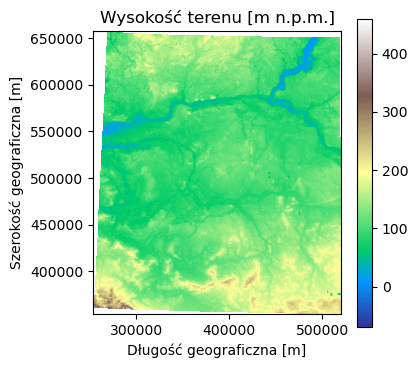

In [8]:
import matplotlib.pyplot as plt

ext = [extent.xMinimum(), extent.xMaximum(), extent.yMinimum(), extent.yMaximum()]
nadata = raster.dataProvider().sourceNoDataValue(1)
data = np.ma.masked_values(array, nadata) # maskowanie wartości

plt.figure(figsize = (4, 4))
plt.imshow(data, extent = ext, cmap = "terrain")
plt.colorbar()
plt.title("Wysokość terenu [m n.p.m.]")
plt.xlabel("Długość geograficzna [m]")
plt.ylabel("Szerokość geograficzna [m]")
plt.show()

# Algebra rastrów

Klasa [QgsRasterCalculator](https://qgis.org/pyqgis/master/analysis/QgsRasterCalculator.html) umożliwia dostęp do [kalkulatora rastrów](https://docs.qgis.org/3.34/en/docs/user_manual/working_with_raster/raster_analysis.html) w QGIS i wykorzystanie różnych operatorów uwzględniając matematyczne, trygonometryczne, porównania czy logiczne (dzięki czemu możliwe jest zamaskowanie czy reklasyfikacja wartości rastra). Potencjalne zastosowania obejmują:
- uwypuklenie form rzeźby terenu wykorzystując współczynnik przewyższenia,
- wyznaczenie dolin rzecznych wykorzystując maskowanie,
- wyznaczenie klas terenu używając prostych reguł klasyfikacyjnych.

Pamiętaj, że w przypadku obliczeń uwzględniających kilka rastrów, to bezwzględnie muszą posiadać jednakowe zasięgi, rozdzielczość oraz układy współrzędnych.

```python
from qgis.analysis import QgsRasterCalculator, QgsRasterCalculatorEntry

a = QgsRasterCalculatorEntry()
a.raster = raster
a.bandNumber = 1
a.ref = "DEM@1"

calculator = QgsRasterCalculator(
    "'DEM@1' * 3",                   # formulaString
    "output.tif",                    # outputFile
    "GTiff",                         # outputFormat
    raster.extent(),                 # outputExtent
    raster.crs(),                    # outputCrs
    raster.width(),                  # nOutputColumns
    raster.height(),                 # nOutputRows
    [a],                             # rasterEntries
    QgsCoordinateTransformContext()  # transformContext
)

status = calculator.processCalculation()

if status != 0:
    print("Błąd zapisu")
else: 
    print("OK")
```

## Maskowanie

Aby stworzyć maskę wartości należy wykorzystać operator logiczny i ustalony warunek, np. wysokość terenu jest mniejsza niż 80 m n.p.m. W ten sposób otrzymamy raster binarny reprezentujący obszary, które spełniają zadany warunek (wartość 1; prawda) oraz nie spełniają (wartość 0; fałsz). Następnie, jeśli przemnożymy maskę przez wartości rastra, to otrzymamy oryginalne wartości dla obszarów spełniających warunek, w przeciwnym razie iloczyn operacji wynosi 0 (czyli komóra zostaje zamaskowana).

```python
# maskowanie
formulaString = "('DEM@1' < 80) * 'DEM@1'"
```

## Reklasyfikacja

W podobny sposób działa reklasyfikacja wartości rastra. Jeśli chcemy zreklasyfikować raster na trzy klasy wysokości, możemy zrobić to w następujący sposób:

```python
# reklasyfikacja
formulaString = "('DEM@1' < 94) * 1 + ('DEM@1' >= 94 AND 'DEM@1' <= 125) * 2 + ('DEM@1' > 125) * 3"
```

# Obliczenie histogramu

In [10]:
from qgis.core import QgsRasterHistogram

provider = raster.dataProvider()
bin_count = 100  # liczba przedziałów w histogramie
elev_max = provider.bandStatistics(1).maximumValue
elev_min = provider.bandStatistics(1).minimumValue

# wyliczenie etykiet dla osi X
step = (elev_max - elev_min) / (bin_count - 1)
labels = [elev_min + i * step for i in range(bin_count)]

# oblicz histogram
histogram = provider.histogram(1, bin_count)
vals = histogram.histogramVector

In [11]:
from qgis.core import QgsHistogram

# optymalizacja liczby przedziałów
bin_optim = QgsHistogram()
bin_optim.setValues(array.flatten())
print(bin_optim.optimalNumberBins())

6243


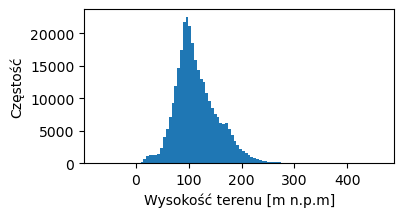

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize = (4, 2))
plt.bar(labels, vals, width = step)
plt.xlabel("Wysokość terenu [m n.p.m]")
plt.ylabel("Częstość")
plt.show()

# Przepróbkowanie

Do przepróbkowania (*resampling*) rastra można wykorzystać dwa zaawansowane programy pochodzące z GDAL, tj. [gdalwarp](https://gdal.org/en/stable/programs/gdalwarp.html) (używany do transformacji rastrów między różnymi układami odniesienia) oraz [gdal_translate](https://gdal.org/en/stable/programs/gdal_translate.html) (używany do konwersji formatu i typów danych). Aby je zastosować należy najpierw zainicjować QGIS (bez tego nie będzie możliwe znalezienie modułów przetwarzania).

```python
# https://docs.qgis.org/latest/en/docs/user_manual/processing_algs/gdal/rasterprojections.html#warp-reproject
from qgis import processing

params = {
    "INPUT": filepath,          # nazwa obiektu lub ścieżka do pliku
    "TARGET_CRS": "EPSG:2180",  # reprojekcja
    "TARGET_RESOLUTION": 1000,  # rozdzielczość
    "RESAMPLING": 0,            # numer metody
    "OUTPUT": "DEM_1000.tif"
}

processing.run("gdal:warpreproject", params)
```

Alternatywnie można użyć odwołań systemowych poprzez moduł Pythona `subprocess` do `qgis_process`.

```python
import subprocess

params = [
    "--INPUT=" + filepath,
    "--TARGET_CRS=EPSG:2180",
    "--TARGET_RESOLUTION=1000",
    "--RESAMPLING=0",
    "--OUTPUT=DEM_1000.tif"
]
result = subprocess.run(["qgis_process", "run", "gdal:warpreproject"] + params,
                        capture_output = True, text = True)
print(result.stdout)
```

# Tworzenie rastra

Tworzenie nowego rastra składa się z trzech zasadniczych kroków:
1. Zainicjowanie pustego rastra na dysku (jeden lub wiele kanałów).
2. Wczytanie wartości i ich zastąpienie.
3. Aktualizacja (nadpisanie) wartości rastra w pliku.

Po operacji zapisu, należy wyłączyć tryb edycji warstwy.

Na początku stwórzmy macierz z wartościami od 1 do 100, którą zapiszemy na dysku.

In [27]:
data = np.arange(1, 101).reshape(10, 10)
print(data)

[[  1   2   3   4   5   6   7   8   9  10]
 [ 11  12  13  14  15  16  17  18  19  20]
 [ 21  22  23  24  25  26  27  28  29  30]
 [ 31  32  33  34  35  36  37  38  39  40]
 [ 41  42  43  44  45  46  47  48  49  50]
 [ 51  52  53  54  55  56  57  58  59  60]
 [ 61  62  63  64  65  66  67  68  69  70]
 [ 71  72  73  74  75  76  77  78  79  80]
 [ 81  82  83  84  85  86  87  88  89  90]
 [ 91  92  93  94  95  96  97  98  99 100]]


```python
ext = QgsRectangle(347000, 454000, 393000, 494000)
crs = QgsCoordinateReferenceSystem("EPSG:2180")

# (1)
writer = QgsRasterFileWriter("test.tif")
provider = writer.createOneBandRaster(
    dataType = Qgis.DataType.Float32,
    width = 10,
    height = 10,
    extent = ext,
    crs = crs
)

# (2)
block = provider.block(1, provider.extent(), provider.xSize(), provider.ySize())
for x in range(block.width()):
    for y in range(block.height()):
        value = data[x][y]
        block.setValue(x, y, value)

# (3)
provider.writeBlock(block, band = 1)
provider.setEditable(False)
```

Zauważ, że dla danych rastrowych typ danych określamy z klasy `Qgis.DataType`, a nie `QMetaType.Type`, jak w przypadku danych wektorowych.

# Łączenie rastrów

Do łączenia kilku jednokanałowych rastrów w jeden wielokanałowy można wykorzystać podejście zaprezentowane w poprzedniej sekcji dotyczącej tworzenia nowego rastra z tą różnicą, iż zamiast metody `createOneBandRaster` należy użyć `createMultiBandRaster`, w której każdy raster zostanie zapisany w pętli jako osobny kanał. Pamiętaj, że rastry muszą posiadać tę samą liczbę wierszy, kolumn, zakres oraz układ przestrzenny. W przeciwnym razie wymagane jest ich wcześniejsze dopasowanie (przepróbkowanie).

Uproszczone podejście opiera się o wykorzystanie dwóch narzędzi GDAL:
1. [gdal_merge](https://gdal.org/en/stable/programs/gdal_merge.html) -- fizycznie łączy dane z wielu rastrów w jeden plik.
2. [gdalbuildvrt](https://gdal.org/en/stable/programs/gdalbuildvrt.html) -- tworzy wirtualny raster (plik z rozszerzeniem `.vrt` oparty o XML), który wyłącznie odwołuje się do wejściowych plików rastrowych bez ich kopiowania, tj. działa jako wskaźnik do oryginalnych plików.

```python
# https://docs.qgis.org/latest/en/docs/user_manual/processing_algs/gdal/rastermiscellaneous.html#merge

params = {
    "INPUT": [filepath, filepath],
    "SEPARATE": True,
    "NODATA_OUTPUT": 9999,
    "OUTPUT": "Merged.tif"
}

processing.run("gdal:merge", params)
```

```python
# https://docs.qgis.org/latest/en/docs/user_manual/processing_algs/gdal/rastermiscellaneous.html#build-virtual-raster

params = {
    "INPUT": [filepath, filepath],
    "SEPARATE": True,
    "OUTPUT": "Merged.vrt"
}

processing.run("gdal:buildvirtualraster", params)
```

# Zadania:

10) Pobierz scenę satelitarną Landsata 8/9 z [EarthExplorer](https://earthexplorer.usgs.gov/), która zawiera kanał panchromatyczny (15 m; produkt L1C) oraz kanały niebieski, zielony i czerwony (30 m; produkt L2A), a następnie zwiększ rozdzielczość przestrzenną kompozycji RGB używając pansharpeningu. W najprostszym wariancie należy uśrednić wartości spektralne kanałów:

```
wynik = (kanał + kanał panchromatyczny) / 2
```

W zaawansowanym wariancie można zastosować inną wybraną technikę pansharpeningu, np. [Brovey'a](https://grass.osgeo.org/grass-stable/manuals/i.pansharpen.html#description). Dla uproszczenia przetwarzania obrazy należy dociąć do mniejszego zakresu przestrzennego. Wynik zapisz na dysku jako obraz składający się z trzech kanałów w formacie `.tif`.